<a href="https://colab.research.google.com/github/nestorsgarzonc/Data-Science-Proyects/blob/master/malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

### Load data

In [0]:
ds_builder=tfds.builder(name='malaria')
print(ds_builder.info)

tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

In [0]:
ds=tfds.load(name='malaria', split='train')
ds_numpy=tfds.as_numpy(ds)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteWWR3ZO/malaria-train.tfrecord



Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [0]:
x = []
y = []
for ex in ds_numpy:
  # `{'image': np.array(shape=(None, None, 1)), 'label': np.array(shape=())}`
  x.append(ex['image'])
  y.append(ex['label'])

# And transform them into numpy arrays
x, y = np.asarray(x), np.asarray(y)

In [0]:
#Liberar memoria
del ds_numpy
del ds

In [0]:
print(x.shape, y.shape)

(27558,) (27558,)


### EDA (Exploratory Data Analysis)

In [0]:
#Imagenes
x.shape

(27558,)

In [0]:
#Labels 0 or 1
y.shape

(27558,)

In [0]:
#Mirar cuantos datos unicos hay
print(np.unique(y, return_counts=True))

(array([0, 1]), array([13779, 13779]))


El dataset esta balanceado

Ahora imprimir las imagenes

In [0]:
#Mostrar aleatoriamente 6 imagenes de las clases deseadas
def plot_imgs(x, y, class_num):
  plt.figure(figsize=(12,12))
  for i in range(6):
    plt.subplot(1,6,i+1)
    random_ind=np.random.randint(0, len(x))

    #Intentar hasta volver a asignar un ejemplo de la clase deseada
    while y[random_ind]!=class_num:
      random_ind=np.random.randint(0, len(x))

    plt.imshow(x[random_ind])
    plt.title(str(class_num))
    plt.tight_layout()
  plt.show()

Imagenes con patologia

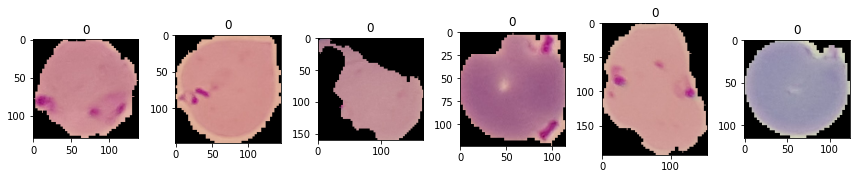

In [0]:
plot_imgs(x,y,0)

Imagenes sin patologia

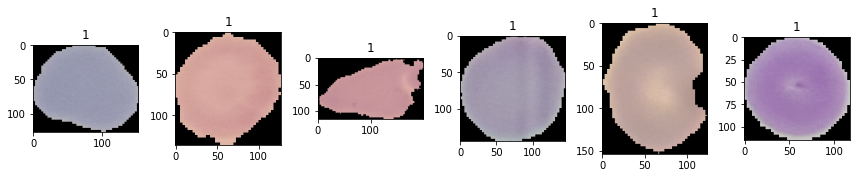

In [0]:
plot_imgs(x,y,1)

### Data preprocessing
 

1.   train test split
2.   standarize
3.   resize
4.   one-shot enconding
5.   pixel value normalization



In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=666)

In [0]:
print('train')
print(x_train.shape, y_train.shape)
print(np.unique(y_train, return_counts=True))

print('test')
print(x_test.shape, y_test.shape)
print(np.unique(y_test, return_counts=True))

train
(19290,) (19290,)
(array([0, 1]), array([9614, 9676]))
test
(8268,) (8268,)
(array([0, 1]), array([4165, 4103]))


Como se puede ver los sets de datos no estan balanceados, para ello usar <strong>STRATIFICATION</strong>

In [0]:
x_train, x_test, y_train, y_test=train_test_split(x,y, stratify=y, test_size=0.3, random_state=666)

print('train')
print(x_train.shape, y_train.shape)
print(np.unique(y_train, return_counts=True))

print('test')
print(x_test.shape, y_test.shape)
print(np.unique(y_test, return_counts=True))

train
(19290,) (19290,)
(array([0, 1]), array([9645, 9645]))
test
(8268,) (8268,)
(array([0, 1]), array([4134, 4134]))


Check mean, min, max

In [0]:
#h=height
#w=width
h_size=[]
w_size=[]

for img in x_test:
  h_size.append(img.shape[0])
  w_size.append(img.shape[1])

h_size, w_size=np.asarray(h_size), np.asarray(w_size)
print('Height')
print(np.min(h_size), np.mean(h_size), np.max(h_size))
print('Width')
print(np.min(w_size), np.mean(w_size), np.max(w_size))

Height
49 132.8178519593614 340
Width
46 132.47206095791 364


In [0]:
#resize img ya que estan en diferentes tamaños
import cv2 #paquete computer vision, tratamiento imagenes
size=50

x_train_input=[]
for i in range(len(x_train)):
  img=cv2.resize(x_train[i], (size, size))
  x_train_input.append(img)

x_train_input=np.asarray(x_train_input)
y_train_input=np.copy(y_train)

print(x_train_input.shape, y_train_input.shape)

(19290, 50, 50, 3) (19290,)


One hot encoding: poner numeero de clases en un vector por cada clase

Ejemplo, infectado o no infectado se puede representar como [infectado, no infectado]
Para n categorias seria: [0, 0, n_categorias]

In [0]:
#data to categorical, modelo general
import keras
num_classes=2
y_train_input=keras.utils.to_categorical(y_train_input, num_classes)

print(y_train_input.shape)

(19290, 2)


Using TensorFlow backend.


Normalize the data
En este caso como son imagenes y los valores van desde 0 hasta 255, hay que dividir el tensor entre 255 aprovechando el broadcasting de python

In [0]:
print(np.min(x_train_input), np.max(x_train_input))

x_train_input = x_train_input*1.0/255.

print(np.min(x_train_input), np.max(x_train_input))

0 255
0.0 1.0


In [0]:
#Data is ready
print('Train')
print(x_train_input.shape, y_train_input.shape)

print('Test')
print(x_test.shape, y_test.shape)

Train
(19290, 50, 50, 3) (19290, 2)
Test
(8268,) (8268,)


In [0]:
def preprocess_data(x_input, y_input, num_classes, size):
  """
  This function do the same that we do before:
  resize the data
  normalize
  data to categorical
  """
  
  x_output=[]
  for i in range(len(x_input)):
    img=cv2.resize(x_input[i], (size, size))
    x_output.append(img)

  x_output=np.asarray(x_output)
  y_output=np.copy(y_input)

  x_output=x_output*1.0/255.

  y_output=keras.utils.to_categorical(y_output, num_classes=num_classes)
  
  return x_output, y_output

In [0]:
x_test_input, y_test_input = preprocess_data(x_test, y_test, num_classes, size)

In [0]:
#Data is ready
print('Train')
print(x_train_input.shape, y_train_input.shape)

print('Test')
print(x_test_input.shape, y_test_input.shape)

Train
(19290, 50, 50, 3) (19290, 2)
Test
(8268, 50, 50, 3) (8268, 2)


### Deep learning
Apply cnn model

## Base model

*    build
*    train
*    evaluate

In [0]:
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K
from keras import optimizers

In [0]:
def CNNbuild(height, width, classes, channels):
  model=Sequential()
  inputShape=(height, width, channels)

  #Feature extractor
  #Conv2D(#filters, (size_filter, size_filter))
  model.add(Conv2D(32, (3,3), activation='relu', input_shape=inputShape))
  model.add(MaxPooling2D(2,2))
  #dropout: desactiva ciertas neuronas con x probabilidad
  model.add(Dropout(0.2))

  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))

  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.2))

  #Fully connected FC
  model.add(Flatten())

  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(classes, activation='softmax'))

  return model

In [0]:
height=x_train_input.shape[1]
width=x_train_input.shape[2]
channels=x_train_input.shape[3]
print(height, width, channels)

model=CNNbuild(height, width, num_classes, channels)

model.summary()

50 50 3
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 32) 

## Model training

In [0]:
#Hyperparameters
epochs=20
batch_size=32

In [0]:
#Compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
h=model.fit(x_train_input, y_train_input, epochs=epochs, batch_size=batch_size, validation_data=(x_test_input, y_test_input))

Train on 19290 samples, validate on 8268 samples
Epoch 1/20
19290/19290 [==============================] - 12s 622us/step - loss: 0.4457 - accuracy: 0.7723 - val_loss: 0.1904 - val_accuracy: 0.9360
Epoch 2/20
19290/19290 [==============================] - 5s 281us/step - loss: 0.1805 - accuracy: 0.9430 - val_loss: 0.1660 - val_accuracy: 0.9473
Epoch 3/20
19290/19290 [==============================] - 5s 279us/step - loss: 0.1633 - accuracy: 0.9480 - val_loss: 0.1444 - val_accuracy: 0.9539
Epoch 4/20
19290/19290 [==============================] - 5s 280us/step - loss: 0.1550 - accuracy: 0.9503 - val_loss: 0.1508 - val_accuracy: 0.9538
Epoch 5/20
19290/19290 [==============================] - 5s 280us/step - loss: 0.1479 - accuracy: 0.9541 - val_loss: 0.1412 - val_accuracy: 0.9548
Epoch 6/20
19290/19290 [==============================] - 5s 278us/step - loss: 0.1465 - accuracy: 0.9543 - val_loss: 0.1456 - val_accuracy: 0.9551
Epoch 7/20
19290/19290 [==============================] - 5s 2

### Model evaluation

In [0]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix

y_pred=model.predict(x_test_input)
#Use argmax
y_pred=np.argmax(y_pred, axis=-1)

acc= accuracy_score(y_test, y_pred)
bac=balanced_accuracy_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)
cm=confusion_matrix(y_test, y_pred)

print('Accuracy: {}'.format(str(acc*100)+'%'))
print('BAC: {}'.format(str(bac*100)+'%'))
print('F1 score: {}'.format(str(f1*100)+'%'))

print(cm)

Accuracy: 95.59748427672956%
BAC: 95.59748427672956%
F1 score: 95.67284831193533%
[[3880  254]
 [ 110 4024]]


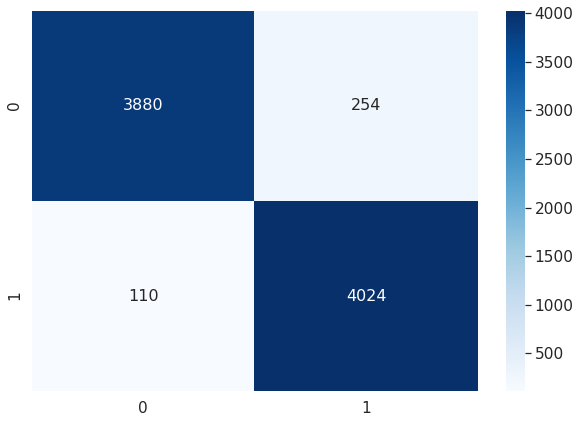

In [0]:
#Plot confusion matrix
import pandas as pd
import seaborn as sn

cm_df=pd.DataFrame(cm, dtype=int)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='g', cmap='Blues')

In [0]:
#Find missclassified samples
ind_error=[]
for i in range(len(y_test)):
  if y_test[i] != y_pred[i]:
    ind_error.append(i)

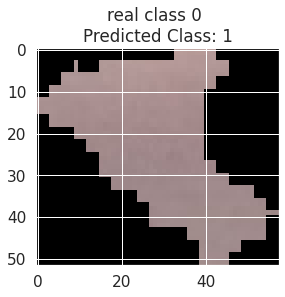

In [0]:
plt.imshow(x_test[ind_error[0]])
plt.title('real class {} \nPredicted Class: {}'.format(y_test[ind_error[0]], y_pred[ind_error[0]]))
plt.show()

### Base model 2

In [0]:
def CNNbuild2(height, width, classes, channels):
  model=keras.Sequential()

  model.add(Conv2D(32, (3,3), padding='same', input_shape=(height, width, 3)))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  
  model.add(Conv2D(64, (3,3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  
  return model


# Create the network

In [0]:
height=x_train_input.shape[1]
width=x_train_input.shape[2]
channels=x_train_input.shape[3]
print(height,width,channels)

model_2=CNNbuild2(height, width, num_classes, channels)
model_2.summary()

50 50 3
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64

# compile the model and train

In [0]:
model_2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
h=model_2.fit(x_train_input, y_train_input, epochs=epochs, 
              batch_size=batch_size, 
              validation_data=(x_test_input, y_test_input)
              )

Train on 19290 samples, validate on 8268 samples
Epoch 1/20
19290/19290 [==============================] - 9s 470us/step - loss: 0.6534 - accuracy: 0.5975 - val_loss: 0.3169 - val_accuracy: 0.8985
Epoch 2/20
19290/19290 [==============================] - 9s 445us/step - loss: 0.5368 - accuracy: 0.6901 - val_loss: 0.1808 - val_accuracy: 0.9253
Epoch 3/20
19290/19290 [==============================] - 9s 443us/step - loss: 0.1884 - accuracy: 0.9330 - val_loss: 0.1716 - val_accuracy: 0.9083
Epoch 4/20
19290/19290 [==============================] - 9s 445us/step - loss: 0.1699 - accuracy: 0.9439 - val_loss: 0.1586 - val_accuracy: 0.9519
Epoch 5/20
19290/19290 [==============================] - 9s 449us/step - loss: 0.1596 - accuracy: 0.9510 - val_loss: 0.1380 - val_accuracy: 0.9523
Epoch 6/20
19290/19290 [==============================] - 9s 444us/step - loss: 0.1494 - accuracy: 0.9528 - val_loss: 0.1607 - val_accuracy: 0.9450
Epoch 7/20
19290/19290 [==============================] - 9s 44

### Base model with augmentation

# Build model

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
train_datagen=ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    zoom_range=0.3,
    rotation_range=30
)
test_datagen=ImageDataGenerator()

train_generator=train_datagen.flow(x_train_input, y_train_input, batch_size=64,
                                   shuffle=False)
test_generator=train_datagen.flow(x_test_input, y_test_input, batch_size=64,
                                   shuffle=False)


In [0]:
#Train model
optim=optimizers.Adam(lr=0.001, decay=0.001/64)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
h_aug=model.fit_generator(train_generator, steps_per_epoch=len(x_train)//64, epochs=10, validation_data=test_generator)

Epoch 1/10
301/301 [==============================] - 20s 67ms/step - loss: 0.2702 - accuracy: 0.9034 - val_loss: 0.1198 - val_accuracy: 0.9109
Epoch 2/10
301/301 [==============================] - 20s 67ms/step - loss: 0.2583 - accuracy: 0.9060 - val_loss: 0.0642 - val_accuracy: 0.9153
Epoch 3/10
301/301 [==============================] - 20s 67ms/step - loss: 0.2570 - accuracy: 0.9075 - val_loss: 0.0323 - val_accuracy: 0.9118
Epoch 4/10
301/301 [==============================] - 20s 66ms/step - loss: 0.2544 - accuracy: 0.9081 - val_loss: 0.1875 - val_accuracy: 0.9065
Epoch 5/10
301/301 [==============================] - 20s 67ms/step - loss: 0.2544 - accuracy: 0.9086 - val_loss: 0.2091 - val_accuracy: 0.9111
Epoch 6/10
301/301 [==============================] - 20s 66ms/step - loss: 0.2532 - accuracy: 0.9080 - val_loss: 0.2051 - val_accuracy: 0.9110
Epoch 7/10
301/301 [==============================] - 20s 66ms/step - loss: 0.2495 - accuracy: 0.9116 - val_loss: 0.1659 - val_accuracy: